In [1]:
import torch
print(torch.__version__)

2.3.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
train_FD001 = pd.read_csv("~/code/meghagkrishnan/jet_engine/raw_data/train_FD001.txt", sep=' ', header=None)
columns = ['unit_number','time_in_cycles','os1', 'os2','os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5',
           'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12','sm13', 'sm14','sm15', 'sm16', 'sm17',
           'sm18', 'sm19','sm20', 'sm21', 'sm22', 'sm23']
train_FD001.columns = columns
train_FD001 = train_FD001.drop(columns=['sm22', 'sm23'])

In [4]:
# calculate RUL
max_cycles = train_FD001.groupby('unit_number')['time_in_cycles'].max()
train_FD001 = train_FD001.merge(max_cycles, on='unit_number', suffixes=('', '_max'))
train_FD001['RUL'] = train_FD001['time_in_cycles_max'] - train_FD001['time_in_cycles']
train_FD001 = train_FD001.drop(columns=['time_in_cycles_max'])

In [5]:
train_FD001 = train_FD001.drop(columns=['os3','sm1','sm5','sm6','sm10','sm16', 'sm18', 'sm19'])

In [6]:
print(train_FD001.columns)

Index(['unit_number', 'time_in_cycles', 'os1', 'os2', 'sm2', 'sm3', 'sm4',
       'sm7', 'sm8', 'sm9', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17',
       'sm20', 'sm21', 'RUL'],
      dtype='object')


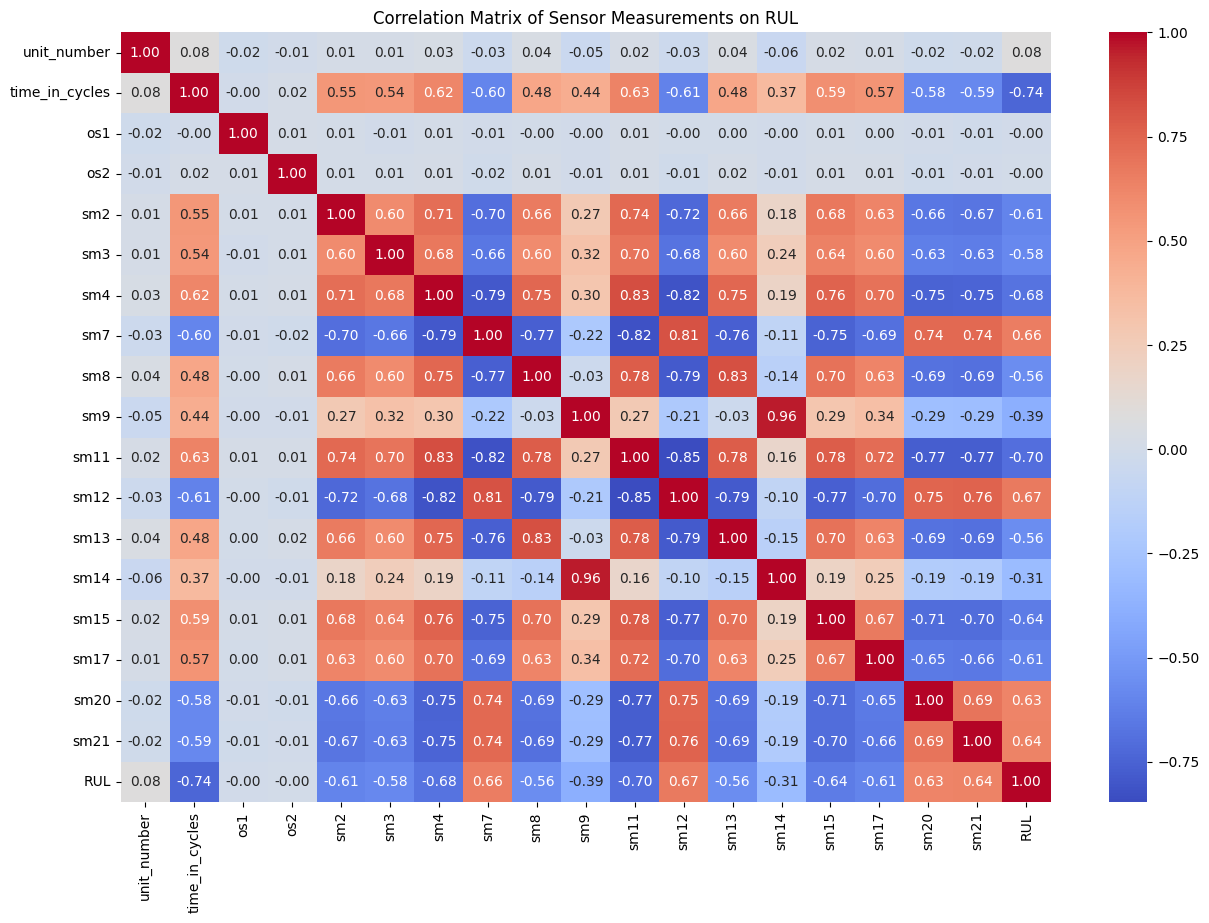

In [7]:
correlation_matrix = train_FD001.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Sensor Measurements on RUL')
plt.show()

In [8]:
#  dont delete 'unit_number','time_in_cycles'
train_FD001 = train_FD001.drop(columns = ['os1','os2'])
X_raw = train_FD001.drop(columns = ['RUL'])
y = train_FD001['RUL']

In [9]:
# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(X_raw)
X = pd.DataFrame(features_normalized, columns=X_raw.columns)
X.head(2)

,unit_number,time_in_cycles,sm2,sm3,sm4,sm7,sm8,sm9,sm11,sm12,sm13,sm14,sm15,sm17,sm20,sm21
0,-1.728084,-1.565170,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.78171,1.348493,1.194427
1,-1.728084,-1.550652,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.78171,1.016528,1.236922


In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16504, 16), (4127, 16), (16504,), (4127,))

In [11]:
# Create linear regression object
base_model = LinearRegression()

# Train the model using the training sets
base_model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_base = base_model.predict(X_test)

# Evaluate the model
r2_base = r2_score(y_test, y_pred_base)
print(f'R² Score: {r2_base}')

mean_squared_error(y_test, y_pred_base)

R² Score: 0.6632010667904993


1538.765324042602

In [12]:
test_FD001 = pd.read_csv("~/code/meghagkrishnan/jet_engine/raw_data/test_FD001.txt",sep = ' ', header=None)
rul_FD001 = pd.read_csv("~/code/meghagkrishnan/jet_engine/raw_data/RUL_FD001.txt", header=None)
columns = ['unit_number','time_in_cycles','os1', 'os2','os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5',
           'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12','sm13', 'sm14','sm15', 'sm16', 'sm17', 
           'sm18', 'sm19','sm20', 'sm21', 'sm22', 'sm23']
test_FD001.columns = columns
test_FD001 = test_FD001.drop(columns = ['sm22', 'sm23'])

rul_FD001.columns = ['RUL']

# Get the max cycle for each unit in the test dataset
max_cycles_test = test_FD001.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles_test.columns = ['unit_number', 'max_time_in_cycles']

# Merge with the RUL values
max_cycles_test = max_cycles_test.merge(rul_FD001, left_index=True, right_index=True)

# Calculate the RUL for each row in the test dataset
test_FD001 = test_FD001.merge(max_cycles_test[['unit_number', 'max_time_in_cycles', 'RUL']], on='unit_number')
test_FD001['RUL'] = test_FD001['RUL'] + (test_FD001['max_time_in_cycles'] - test_FD001['time_in_cycles'])
test_FD001 = test_FD001.drop(columns=['max_time_in_cycles'])

#  dont delete 'unit_number','time_in_cycles'
test_FD001 = test_FD001.drop(columns = ['os1','os2','os3','sm1','sm5','sm6','sm10','sm16', 'sm18', 'sm19'])
test_FD001.head()

,unit_number,time_in_cycles,sm2,sm3,sm4,sm7,sm8,sm9,sm11,sm12,sm13,sm14,sm15,sm17,sm20,sm21,RUL
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138


In [13]:
print(train_FD001.columns)
print(test_FD001.columns)

Index(['unit_number', 'time_in_cycles', 'sm2', 'sm3', 'sm4', 'sm7', 'sm8',
       'sm9', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21',
       'RUL'],
      dtype='object')
Index(['unit_number', 'time_in_cycles', 'sm2', 'sm3', 'sm4', 'sm7', 'sm8',
       'sm9', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21',
       'RUL'],
      dtype='object')


In [14]:
# create time series features:
def create_sequence_features(df, window_size=10):
    sequence_features = []
    for unit in df['unit_number'].unique():
        unit_data = df[df['unit_number'] == unit].sort_values('time_in_cycles')
        for col in df.columns:
            if col not in ['unit_number', 'time_in_cycles', 'RUL']:
                unit_data[f'{col}_rolling_mean'] = unit_data[col].rolling(window=window_size).mean()
                unit_data[f'{col}_rolling_std'] = unit_data[col].rolling(window=window_size).std()
        sequence_features.append(unit_data)
    return pd.concat(sequence_features).reset_index(drop=True)

In [15]:
# apply time series feature creation
train_FD001 = create_sequence_features(train_FD001)
test_FD001 = create_sequence_features(test_FD001)

In [16]:
print(y.isna().sum())

0


In [17]:
print(X['unit_number'].dtype)

float64


In [18]:
print(f"Shape of X: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

Shape of X: (20631, 16)
Number of features: 16
Number of samples: 20631


In [19]:
# remove features that might cause data leakage 
# The presence of the ‘time_in_cycles’ feature might cause data leakage because it could be directly related to the target variable RUL.
X = X.drop(['time_in_cycles'], axis=1)

In [20]:
# reduce the number of features,keep original sensor data.
original_features = ['unit_number', 'sm2', 'sm3', 'sm4', 'sm7', 'sm8', 'sm9', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21']
X = X[original_features]

In [21]:
print(X.columns)

Index(['unit_number', 'sm2', 'sm3', 'sm4', 'sm7', 'sm8', 'sm9', 'sm11', 'sm12',
       'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21'],
      dtype='object')


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

#  define preprocessor and pipeline
numeric_features = [col for col in X.columns if col not in ['unit_number']]
categorical_features = ['unit_number']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False))
        ]), categorical_features)
    ])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# split data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression (Pipeline)  MSE: {mse}, R2: {r2}")

Linear Regression (Pipeline)  MSE: 1050.6567529082297, R2: 0.7700363609577592


Model Random Forest Regressor

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# data preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creat RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# define the parameter space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# use random search
random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist, 
                                   n_iter=20, cv=2, n_jobs=-1, verbose=2, 
                                   scoring='neg_mean_squared_error', random_state=42)

# fit on a smaller data subset
sample_size = min(10000, len(X_train))  
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)

random_search.fit(X_sample, y_sample)

print("Best parameters:", random_search.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [28]:
# use best parameters on the full training set
best_rf = RandomForestRegressor(**random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# prediction on the test set
y_pred = best_rf.predict(X_test)

#  evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest  MSE: {mse}, R2: {r2}")


Random Forest  MSE: 904.4871282720745, R2: 0.8020293964621953


In [29]:
# the feature importance
feature_importance = best_rf.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

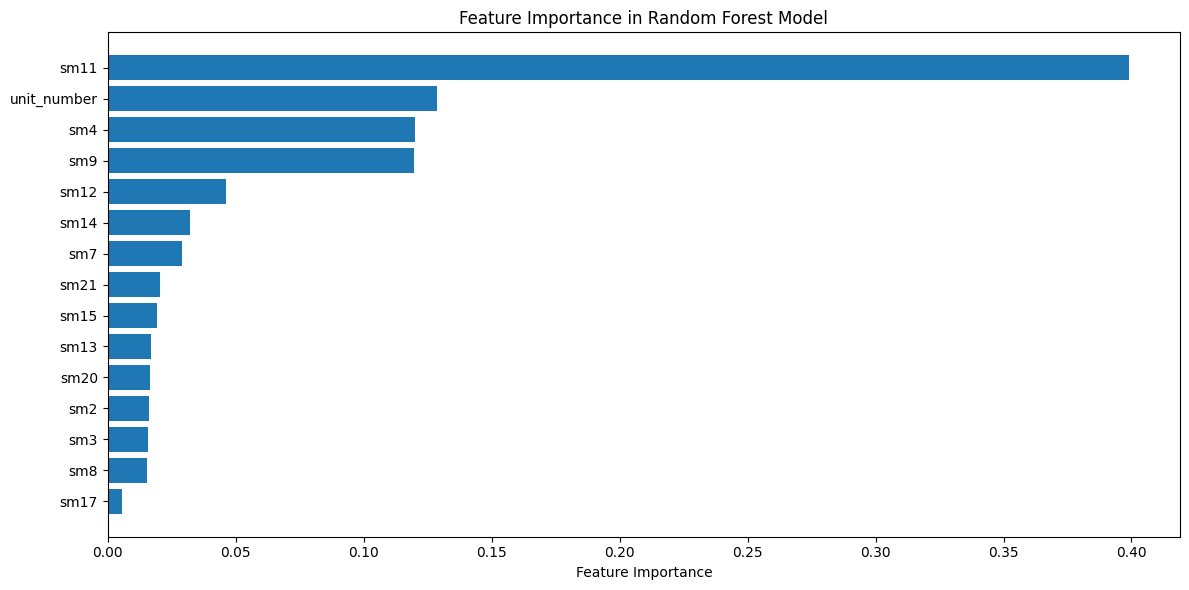

In [30]:
# visualize the feature importance
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

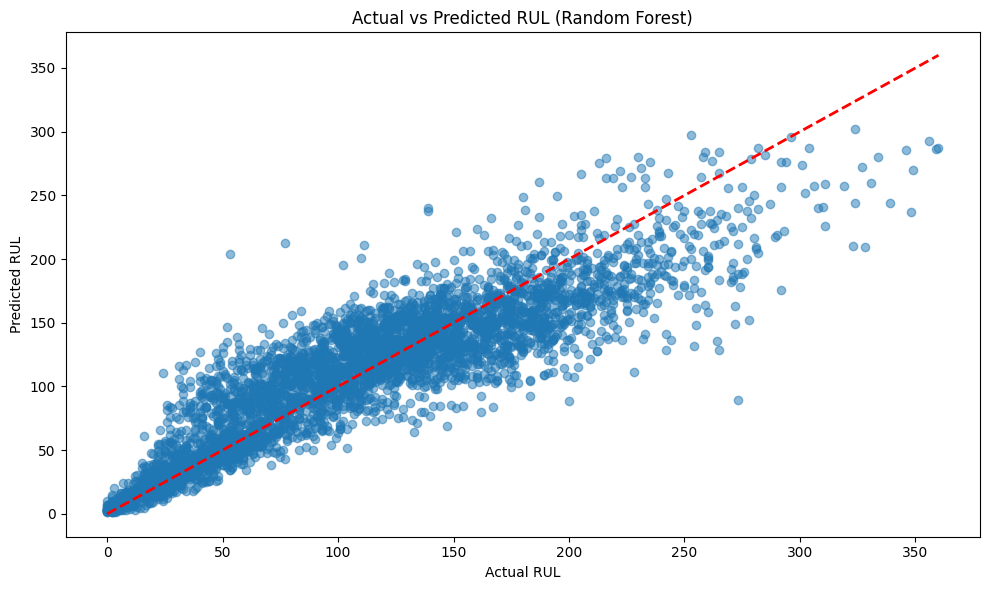

In [31]:
# visualize the prediction results:

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (Random Forest)')
plt.tight_layout()
plt.show()

MODEL MLP Regressor

In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standard feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create and train model
model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

# prediction
y_pred = model.predict(X_test_scaled)

# evaluate 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLP Model  MSE: {mse}, R2: {r2}")

MLP Model  MSE: 1482.0338811836689, R2: 0.6756182230233463


/Users/zenajo/.pyenv/versions/3.10.6/envs/jet_engine/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


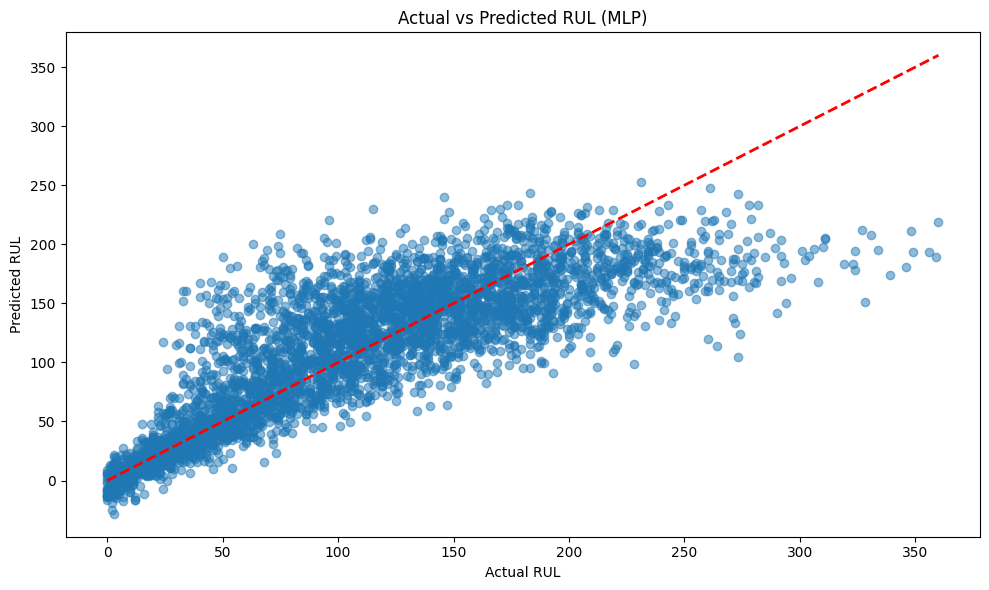

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (MLP)')
plt.tight_layout()
plt.show()

LSTM

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1).to(device)


In [27]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [43]:
model = LSTMModel(input_size=X_train_scaled.shape[1], hidden_size=50, num_layers=1, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
num_epochs = 100
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 1307.6696
Epoch [20/100], Loss: 1256.0466
Epoch [30/100], Loss: 1241.4998
Epoch [40/100], Loss: 1182.5774
Epoch [50/100], Loss: 1138.8486
Epoch [60/100], Loss: 1116.2373
Epoch [70/100], Loss: 1107.6896
Epoch [80/100], Loss: 1101.4358
Epoch [90/100], Loss: 1091.4559
Epoch [100/100], Loss: 1070.0892


In [45]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

In [46]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [47]:
print(f"LSTM Model MSE: {mse}, R2: {r2}")

LSTM Model MSE: 1585.3531557874214, R2: 0.6530041098594666


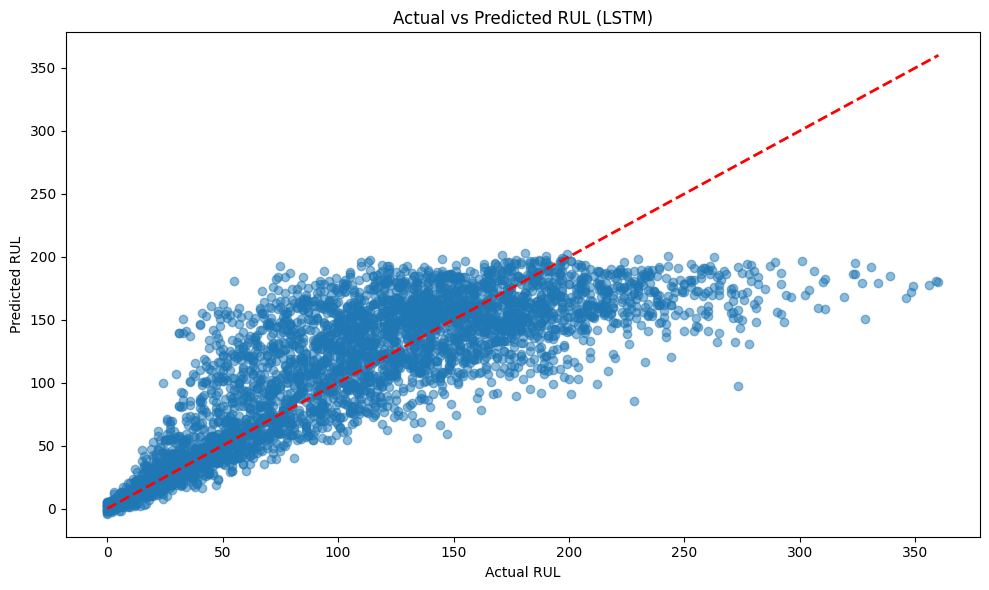

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (LSTM)')
plt.tight_layout()
plt.show()